In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

import os
import time
import itertools
import warnings
warnings.filterwarnings("ignore")

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt


In [2]:
ts = pd.read_csv('../../data/ts_top100_prediction.csv')
ts.head(5)

,date,id,item,sales,income,event
0,2011-01-29,ACCESORIES_1_108_NYC_1,ACCESORIES_1_108,4,64.4784,0
1,2011-01-29,HOME_&_GARDEN_1_027_NYC_1,HOME_&_GARDEN_1_027,4,26.2000,0
2,2011-01-29,HOME_&_GARDEN_1_053_NYC_1,HOME_&_GARDEN_1_053,0,0.0000,0
3,2011-01-29,HOME_&_GARDEN_1_140_NYC_1,HOME_&_GARDEN_1_140,4,75.0000,0
4,2011-01-29,HOME_&_GARDEN_1_177_NYC_1,HOME_&_GARDEN_1_177,0,0.0000,0


In [3]:
df_product = ts[['date', 'item','sales']]

In [4]:
df_product.head(2)

,date,item,sales
0,2011-01-29,ACCESORIES_1_108,4
1,2011-01-29,HOME_&_GARDEN_1_027,4


In [5]:
df_SUPERMARKET_3_586 = df_product[df_product['item']=='SUPERMARKET_3_586']

In [6]:
ts_predict = df_SUPERMARKET_3_586.groupby(['date'])['sales'].sum().reset_index() #ts=suma de todas las ventas de todas las tiendas agrupado por día

In [7]:
ts_predict.set_index('date', inplace=True)

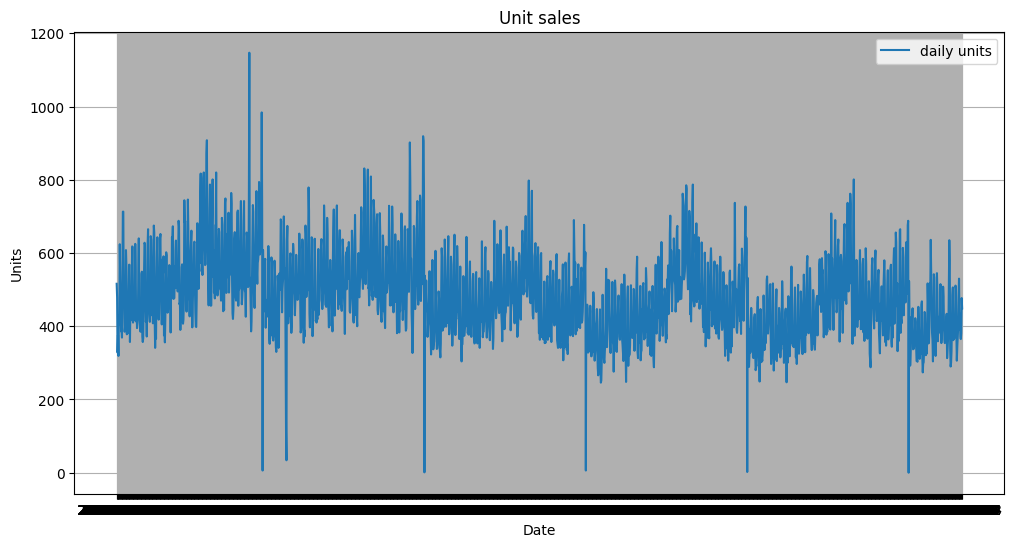

In [8]:
import matplotlib.pyplot as plt

# Graficar la serie temporal
plt.figure(figsize=(12, 6))
plt.plot(ts_predict.index, ts_predict['sales'], label='daily units')
plt.xlabel('Date')
plt.ylabel('Units')
plt.title('Unit sales')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(ts_predict['sales'])
print(f'Estadístico ADF: {result[0]}')
print(f'Valor p: {result[1]}')

Estadístico ADF: -3.281283726702086
Valor p: 0.015736104534793915


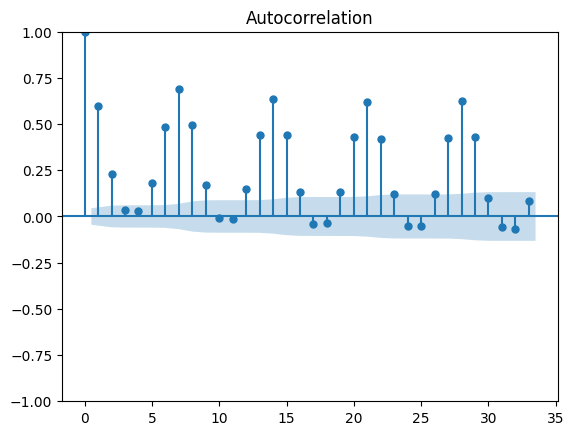

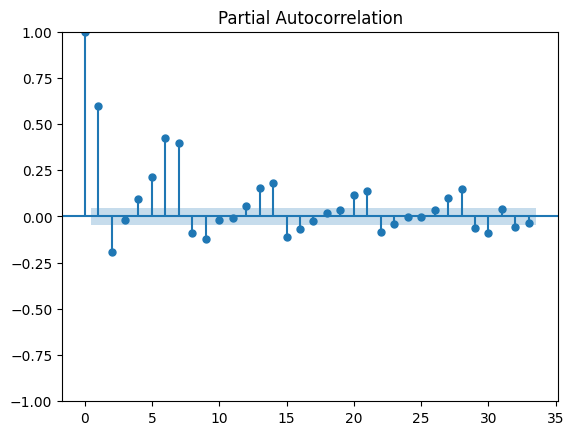

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_predict)
plt.show()

plot_pacf(ts_predict)
plt.show()

In [11]:
df_train = ts_predict[:-30]
df_test = ts_predict[-30:]

In [12]:
df_train

,sales
date,
2011-01-29,516
2011-01-30,479
2011-01-31,328
2011-02-01,376
2011-02-02,319
...,...
2016-03-21,313
2016-03-22,335
2016-03-23,361


In [13]:
pdq = [
    (1, 0, 1), (1, 0, 2),
    (2, 0, 3), (2, 0, 4),
    (2, 0, 5), (2, 0, 1),
    (2, 0, 2), (2, 0, 3),
    (2, 0, 4),

    
    
    # Opciones con d = 1 (por si acaso)
    # (1, 1, 1), (1, 1, 2),
    # (2, 1, 1), (2, 1, 2)

    (1, 1, 1), (1, 1, 2),
    (2, 1, 3), (2, 1, 4),
    (2, 1, 5), (2, 1, 1),
    (2, 1, 2), (2, 1, 3),
    (2, 1, 4), (2, 1, 5)
]

# Probar también con algún P o Q diferente de 0 en la parte estacional
seasonal_pdq = (0, 1, 0, 7) # Actual
#     (1, 1, 0, 7),  # AR estacional
#     (0, 1, 1, 7),  # MA estacional
#     (1, 1, 1, 7)   # AR y MA estacional

In [14]:
RESULTS_DICT = {}

for param in pdq:

    model = sm.tsa.statespace.SARIMAX(
        endog = df_train,
        order = param,
        seasonal_order = seasonal_pdq,
        enforce_stationarity = False,
        enforce_invertibility = False
    )

    model_fitted = model.fit()

    print('ARIMA{}x{}12 - AIC:{}'.format(param, seasonal_pdq, model_fitted.aic))

    RESULTS_DICT[param] = round(model_fitted.aic, 2)

c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(1, 0, 1)x(0, 1, 0, 7)12 - AIC:21990.395323858298
ARIMA(1, 0, 2)x(0, 1, 0, 7)12 - AIC:21980.798988491762


c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 0, 3)x(0, 1, 0, 7)12 - AIC:21699.119901878257


c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Val

ARIMA(2, 0, 4)x(0, 1, 0, 7)12 - AIC:21673.91574070271


c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 0, 5)x(0, 1, 0, 7)12 - AIC:21539.345131235837
ARIMA(2, 0, 1)x(0, 1, 0, 7)12 - AIC:21992.381555751075


c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 0, 2)x(0, 1, 0, 7)12 - AIC:21947.484269616078


c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 0, 3)x(0, 1, 0, 7)12 - AIC:21699.119901878257


c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Val

ARIMA(2, 0, 4)x(0, 1, 0, 7)12 - AIC:21673.91574070271
ARIMA(1, 1, 1)x(0, 1, 0, 7)12 - AIC:21994.287183740635


c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 2)x(0, 1, 0, 7)12 - AIC:21977.02749353811


c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Val

ARIMA(2, 1, 3)x(0, 1, 0, 7)12 - AIC:21784.37881785048


c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 4)x(0, 1, 0, 7)12 - AIC:21699.26348722318


c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 5)x(0, 1, 0, 7)12 - AIC:21779.80352239193


c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 1)x(0, 1, 0, 7)12 - AIC:21988.998218664063


c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 2)x(0, 1, 0, 7)12 - AIC:22002.884897134503


c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Val

ARIMA(2, 1, 3)x(0, 1, 0, 7)12 - AIC:21784.37881785048


c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 4)x(0, 1, 0, 7)12 - AIC:21699.26348722318
ARIMA(2, 1, 5)x(0, 1, 0, 7)12 - AIC:21779.80352239193


c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [15]:
gsx = list(map(str, list(RESULTS_DICT.keys())))
gsy = list(RESULTS_DICT.values())

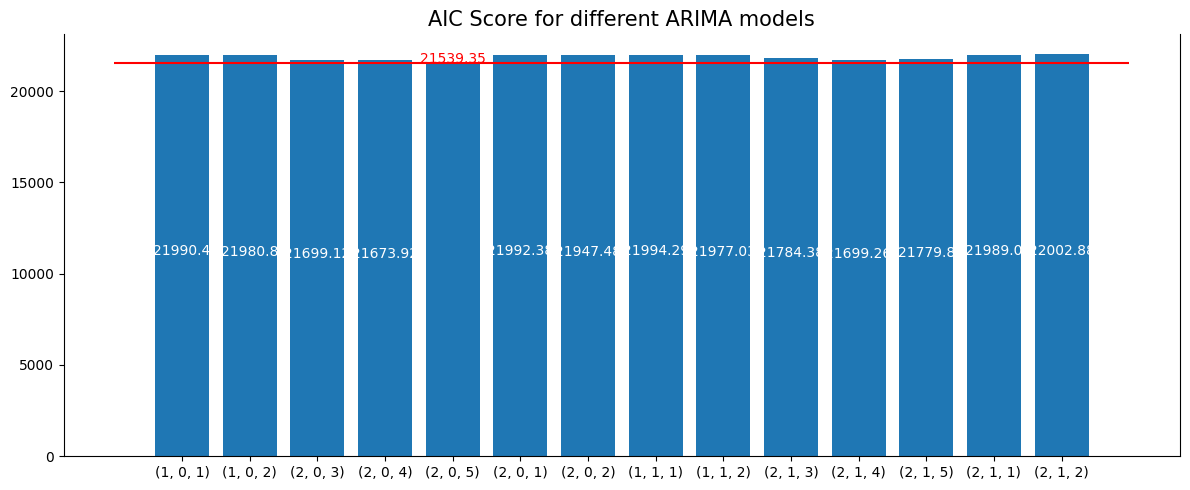

In [16]:
fig = plt.figure(figsize = (12, 5))
ax = fig.add_subplot()

ax.bar(x = gsx, height = gsy)
ax.hlines(y = min(gsy), xmin = -1, xmax = len(gsx), color = "red")

for xtick_, y_ in zip(gsx, gsy):

    s_ = str(round(y_, 2))

    ax.text(
        x = xtick_,
        y = y_/2 if y_ != min(gsy) else y_ + 10,
        s = s_,
        ha = "center",
        color = "red" if y_ == min(gsy) else "white"
    )

ax.spines["top"].set_color("None")

plt.title(label = "AIC Score for different ARIMA models", fontsize = 15)
plt.tight_layout()

In [17]:
RESULTS_DICT

{(1, 0, 1): np.float64(21990.4),
 (1, 0, 2): np.float64(21980.8),
 (2, 0, 3): np.float64(21699.12),
 (2, 0, 4): np.float64(21673.92),
 (2, 0, 5): np.float64(21539.35),
 (2, 0, 1): np.float64(21992.38),
 (2, 0, 2): np.float64(21947.48),
 (1, 1, 1): np.float64(21994.29),
 (1, 1, 2): np.float64(21977.03),
 (2, 1, 3): np.float64(21784.38),
 (2, 1, 4): np.float64(21699.26),
 (2, 1, 5): np.float64(21779.8),
 (2, 1, 1): np.float64(21989.0),
 (2, 1, 2): np.float64(22002.88)}

In [18]:
idx_min_score_aic = np.argmin(list(RESULTS_DICT.values()))
pdq_min_score_aic = list(RESULTS_DICT.keys())[idx_min_score_aic]
min_score_aic = RESULTS_DICT[pdq_min_score_aic]

message = f'''
El score mínimo se alcanza con ARIMA{pdq_min_score_aic}
Con un score AIC de {min_score_aic}.
En la posición {idx_min_score_aic}
'''

print(message)


El score mínimo se alcanza con ARIMA(2, 0, 5)
Con un score AIC de 21539.35.
En la posición 4



In [19]:
best_arima_model = sm.tsa.statespace.SARIMAX(
    endog = df_train,
    order = (2,0,4),
    seasonal_order = seasonal_pdq,
    enforce_stationarity = False,
    enforce_invertibility = False
)

best_arima_model_fitted = best_arima_model.fit()

c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [20]:
print(best_arima_model_fitted.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9983      0.022     44.467      0.000       0.954       1.042
ar.L2         -0.6493      0.018    -36.744      0.000      -0.684      -0.615
ma.L1         -0.7973      0.024    -33.236      0.000      -0.844      -0.750
ma.L2          0.6645      0.024     27.202      0.000       0.617       0.712
ma.L3          0.1608      0.025      6.410      0.000       0.112       0.210
ma.L4          0.2279      0.025      9.008      0.000       0.178       0.277
sigma2      6762.6330     98.110     68.929      0.000    6570.341    6954.925


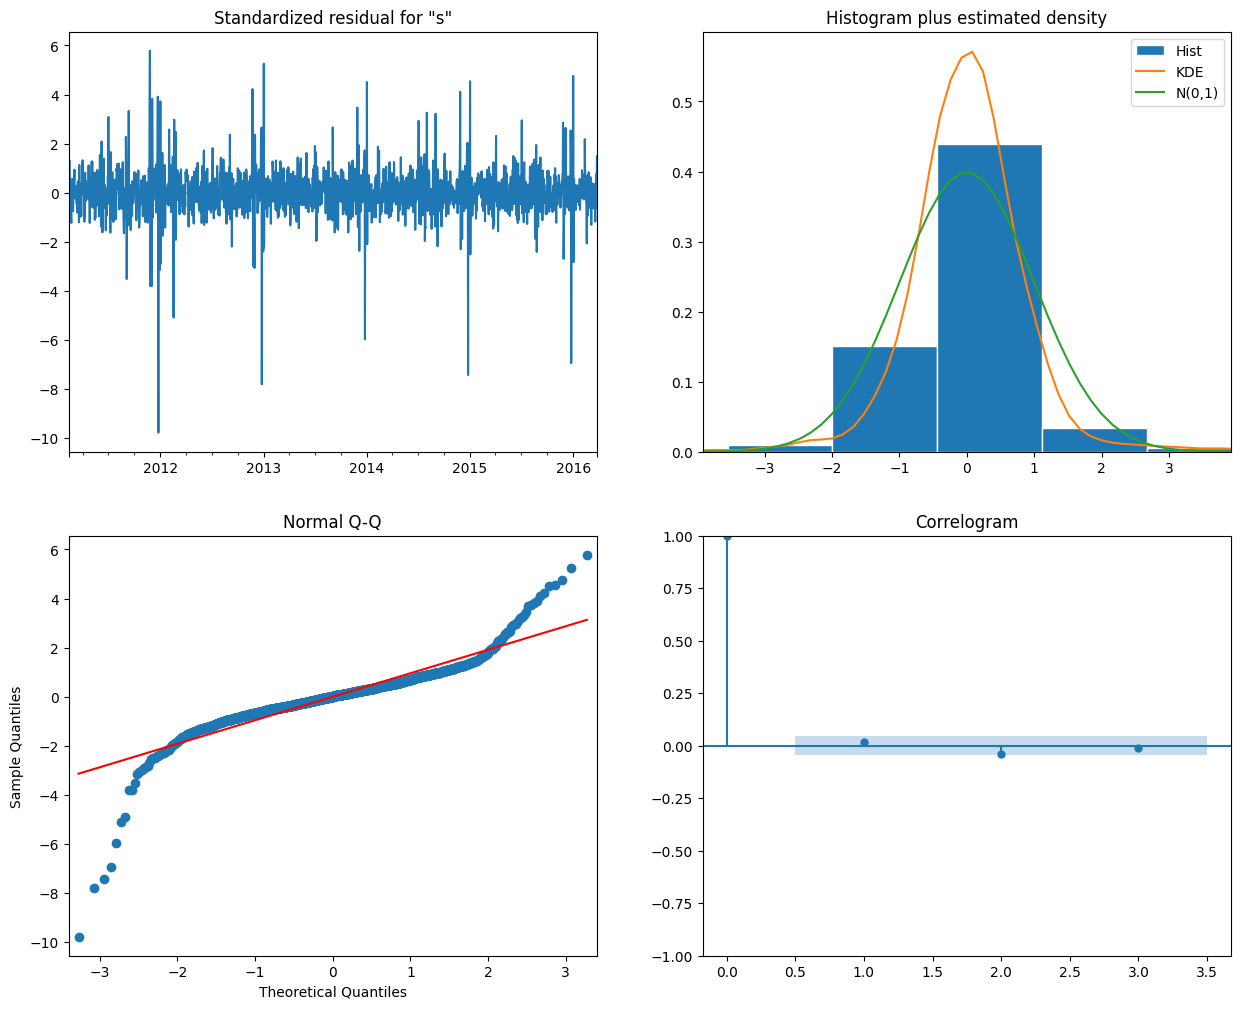

In [21]:
best_arima_model_fitted.plot_diagnostics(figsize = (15, 12), lags = 3);

In [ ]:
pred_uc = best_arima_model_fitted.get_forecast(steps = len(df_test))
y_pred_test = pred_uc.predicted_mean

# 1. Calculate MSE
mse = mean_squared_error(df_test['sales'], y_pred_test)
print(f'The error MSE is : {mse}')
# 2. Calculate RMSPE
rmspe = np.sqrt(np.mean(((df_test - y_pred_test) / df_test) ** 2)) * 100
print(f'The error RMSPE is: {rmspe:.2f}%')
rmse = np.sqrt(mean_squared_error(df_test['sales'], y_pred_test))
print(f'RMSE: {rmse}')

In [ ]:
resultado = {'predicion': y_pred_test.values, 'test':df_test['sales']}

In [24]:
pd.DataFrame(resultado)

,predicion,test
date,,
2016-03-26,487.439490,635
2016-03-27,511.329712,579
2016-03-28,369.120340,339
2016-03-29,368.665895,290
2016-03-30,358.168933,300
2016-03-31,366.314486,332
2016-04-01,481.195183,405
2016-04-02,480.702261,485
2016-04-03,519.411280,506


In [25]:
ts_predict.reset_index(inplace=True)
ts_predict['date'] = pd.to_datetime(ts_predict['date'])
ts_predict.set_index('date', inplace=True)
#y_pred_test.set_index('date', inplace=True)

Text(0.5, 0.98, 'Lynx Values and ARIMA Forecast')

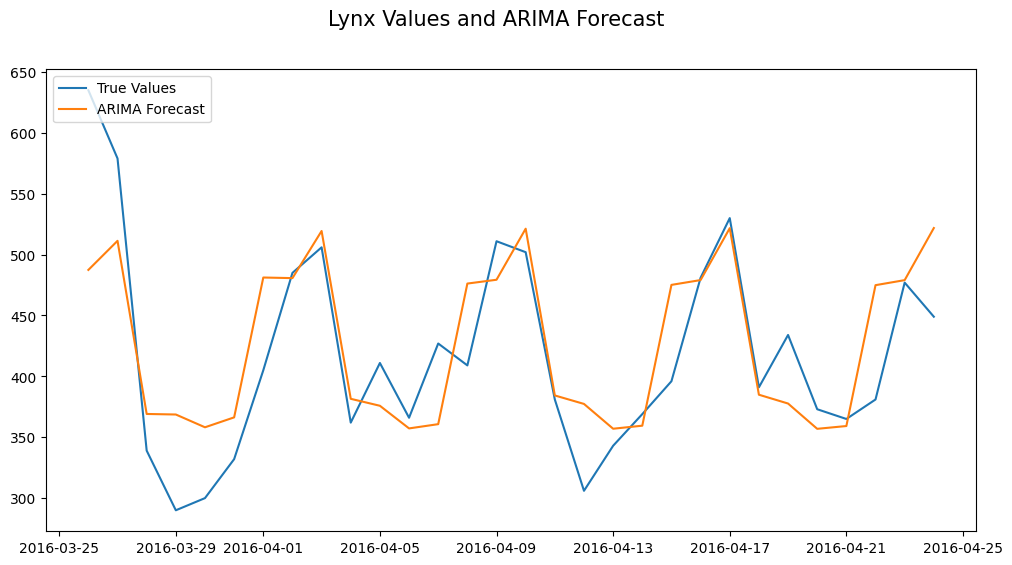

In [26]:
fig = plt.figure(figsize = (12, 6))
ax = fig.subplots()

ax.plot(ts_predict[-30:], label = "True Values")
ax.plot(y_pred_test, label = "ARIMA Forecast")

ax.legend(loc = "upper left")
fig.suptitle("Lynx Values and ARIMA Forecast", fontsize = 15)